# Detection and Quantification of Microspots

---

**Updated on:** 2023-09-25

> Authors: Simon Knoblauch (simon.knoblauch@student.uni-tuebingen.de)  
> Input file(s): .tif, .png, .jpg containing spots  
> Output file(s): .csv file containing data on all detected spots  
> Dependencies: imageio, pandas, numpy, skimage, matplotlib, ipympl, pathlib, math 

**Please read the comments before proceeding to run the code and let us know if you run into any errors or find undocumented pieces of code.**

In [176]:
# Importing dependencies
import imageio.v3 as iio
import pandas as pd
import skimage
import matplotlib.pyplot as plt
import numpy as np
import ipympl
from pathlib import Path
import math
%matplotlib widget

## User Input

In [177]:
inputfile=Path(r"test_images\edge_halo.tif")
outputfolder=Path(r"output")

first_spot="A1"
last_spot="P20"

### Extracting Information from User Input

In [192]:
def conv_gridinfo(point1:str,point2:str,conv_dict:dict) -> dict:
    """
    ## Description:
    Takes in information on the first and last point on a uniformly spaced grid and converts it into the grids properties.

    ## Input:

    |Parameter|Type|Description|
    |---|---|---|
    |point1|str|First Point on the grid. The first character determines row, the rest determine column.|
    |point2|str|Last Point on the grid. The first character determines row, the rest determine column.|
    |conv_dict|dict|Dictionary by which the row characters are converted to numeric values.|

    ## Output:

    Dictionary of grid properties.
    """

    # Determining the indexes of the first and last row
    firstrow_nr=conv_dict[point1[0].lower()]
    lastrow_nr=conv_dict[point2[0].lower()]
    rowcount=lastrow_nr-firstrow_nr+1

    # Determining the indexes of the first and last column
    firstcol_nr=int(point1[1:])
    lastcol_nr=int(point2[1:])
    colcount=lastcol_nr-firstcol_nr+1

    # Calculating the number of total spots
    nr_spots=rowcount*colcount

    # Storing results in Dictionary.
    grid_properties={
        "rows":{
            "bounds":[firstrow_nr,lastrow_nr],
            "length":rowcount},
        "columns":{
            "bounds":[firstcol_nr,lastcol_nr],
            "length":colcount},
        "spot_nr":nr_spots}
    
    return grid_properties

In [179]:
# Dictionaries to convert Row-Letters into Row-Numbers and vice versa.
row_conv={"abcdefghijklmnopqrstuvwxyz"[i-1]: i for i in range(1,27)}
row_conv_inv={v:k for k,v in row_conv.items()}

grid_props=conv_gridinfo(first_spot,last_spot,row_conv)

## Loading the Image File

In [180]:
def prep_img(filename:Path,invert:bool=False) -> np.array:
    """
    ## Description
    Loads a grayscale, RGB or RGBA image from a filepath and returns a grayscale array of the image.
    
    ## Input

    |Parameter|Type|Description|
    |---|---|---|
    |filename|Path, Str|Relative or absolute path of the image to be loaded.|
    |invert|bool|Set True if the image should be inverted.|

    ## Output

    Grayscale Numpy Array of the image.

    """
    
    # Read image file.
    load=iio.imread(filename)

    # Check if image is RGBA and convert image to grayscale.
    if load.shape[2]==4:
        gray_img=skimage.color.rgb2gray(load[:,:,0:3])

    # Convert RGB images to grayscale.
    elif load.shape[2]==3:
        gray_img=skimage.color.rgb2gray(load)
    
    else:
        gray_img=load

    # Invert the intensity values. Comment out if you do not wish to invert the image.
    if invert:
        gray_img=skimage.util.invert(gray_img)
    
    return gray_img

[Text(0.5, 1.0, 'Grayscale Image')]

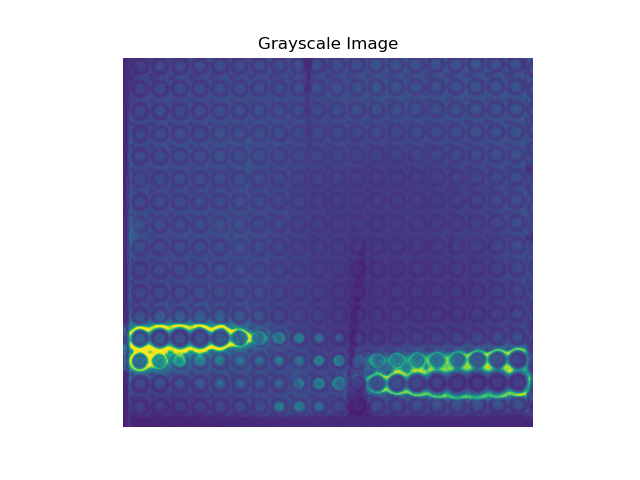

In [181]:
# Load and prepare raw image file.
raw_img=prep_img(inputfile, invert=True)

# Display the grayscale image using the "viridis" colormap.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Grayscale Image")


## Inital Spot Detection

In [194]:
class spot:
    """
    ## Description

    Class containing information on spots detected during spot-detection

    ## __init__ Input:

    |Parameter|Type|Description|
    |---|---|---|
    |x|float|x-coordinate of the spot|
    |y|float|y-coordinate of the spot|
    |rad|int|radius of the spot|
    |halo_rad|int|radius of the halo of the spot|
    |int|float|Average pixel-intensity of the spot|
    |note|str|Arbitrary String|
    |row|int|Row-Index of spot in grid|
    |col|int|Column-Index of spot in grid|
    |row_name|str|Name of Row|

    ## Class Attributes

    |Name|Description|
    |---|---|
    |x|x-coordinate of the spot|
    |y|y-coordinate of the spot|
    |rad|radius of the spot|
    |halo|radius of the halo of the spot|
    |int|Average pixel-intensity of the spot|
    |note|Arbitrary String|
    |row|Row-Index of spot in grid|
    |col|Column-Index of spot in grid|
    |row_name|Name of Row|
    """
    def __init__(self,x:float,y:float,rad:int=25,halo_rad=np.nan,int=np.nan,note="Initial Detection",row:int=np.nan,col:int=np.nan,row_name:str=np.nan) -> None:
        self.x=x
        self.y=y
        self.rad=rad
        self.halo=halo_rad
        self.int=int
        self.note=note
        self.row=row
        self.col=col
        self.row_name=row_name
    
    def assign_halo(self,halo_list:list) -> None:
        """
        ## Description
        Checks a list of halos for a match and assigns it to the spot.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |halo_list|int|List of halo-objects|
        """
        for h in halo_list:
            if np.linalg.norm(np.array((h.x,h.y))-np.array((self.x,self.y)))<14.73402725:
                self.halo=h.rad
            

    def get_intensity(self,img:np.array) -> None:
        """
        ## Description
        Determines the average pixel-intensity of a spot in an image.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |img|np.array|Image to extract spot-intensity from|
        
        ## Output

        Avgerage intensity of pixels in spot.
        """
        try:
            # Indices of all pixels part of the current spot
            rr,cc=skimage.draw.disk((self.y,self.x),self.rad)
            # Mean intensity of all pixels within the spot
            self.int=raw_img[rr,cc].sum()/len(rr)
            return self.int
    
        except:
            print(f"Spot at Coordinates ({self.x}, {self.y}) could not be evaluated: (Partly) Out of Bounds.")
        
    def append_df(self,spot_df:pd.DataFrame) -> pd.DataFrame:
        """
        ## Description

        Adds current spot to an existing spot-DataFrame

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |spot_df|DataFrame|DataFrame that the current spot should be added to|

        ## Output

        Updated DataFrame
        """
        new_df=pd.concat([spot_df,pd.Series({"row":self.row,
                                             "row_name":self.row_name,
                                             "column":self.col,
                                             "x_coord":self.x,
                                             "y_coord":self.y,
                                             "radius":self.rad,
                                             "halo":self.halo,
                                             "spot_intensity:":self.int,
                                             "note":self.note}).to_frame().T],ignore_index=True)
        return new_df

    def draw_spot(self,image:np.array,value:float=1,radius:int=None) -> np.array:
        """
        ## Description

        Inserts the spot into an image with the given value and radius.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |image|Array|Image that the spot will be inseted into.|
        |value|float|Numeric value of the pixels of the spot.|
        |radius|int|Radius of the spot to be drawn if none is given, the radius attribute is called.|

        ## Output

        Array of Image with the spot inserted.
        """
        
        # Get the radius of the spot using its rad attribute if no radius is given.
        if radius==None: radius=self.rad
        
        # Get the indices of the spot
        rr,cc=skimage.draw.disk((self.y,self.x),radius)

        # Draw the spot into the image, if the spot is out of bounds return Message.
        try:
            image[rr,cc]=value
        except:
            print(f"Spot at Coordinates ({self.x}, {self.y}) could not be drawn: Out of Bounds.")
        return image

    @staticmethod
    def detect(gray_img:np.array,spot_nr:int) -> list:
        """
        ## Description

        Crude detection of spots in a grayscale image.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |gray_img|np.array|Grayscale np.array of image to be analyzed|
        |spot_nr|int|Maximum number of spots to be detected in the image|

        ## Output

        List of detected spots as spot-objects
        """

        histeq_img=skimage.filters.rank.equalize(skimage.util.img_as_ubyte(gray_img),skimage.morphology.disk(50))
        edges=skimage.feature.canny(
        image=histeq_img,
        sigma=10,
        low_threshold=0.001,
        high_threshold=0.001
        )

        # Range of Radii that are tested during inital spotdetection.
        tested_radii=np.arange(20,31)

        # Hough transform for a circle of the edge-image and peak detection to find circles in earlier defined range of radii.
        spot_hough=skimage.transform.hough_circle(edges,tested_radii)
        accums,spot_x,spot_y,spot_rad=skimage.transform.hough_circle_peaks(
            hspaces=spot_hough,
            radii=tested_radii,
            total_num_peaks=spot_nr,
            min_xdistance=70,
            min_ydistance=70,
            threshold=0.3*spot_hough.max()
            )
        
        spotlist=[spot(x,y,rad) for x,y,rad in zip(spot_x,spot_y,spot_rad)]
        
        return spotlist
    
    @staticmethod
    def create_df(spot_list:list) -> pd.DataFrame:
        """
        ## Description

        Creates a DataFrame from a list of spots.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |spot_list|list|List of spot-objects to be turned into a DataFrame|

        ## Output

        DataFrame of spot-list.
        """

        spot_df=pd.DataFrame({"row":[i_spot.row for i_spot in spot_list],
                              "row_name":[i_spot.row_name for i_spot in spot_list],
                              "column":[i_spot.col for i_spot in spot_list],
                              "x_coord":[i_spot.x for i_spot in spot_list],
                              "y_coord":[i_spot.y for i_spot in spot_list],
                              "radius":[i_spot.rad for i_spot in spot_list],
                              "halo":[i_spot.halo for i_spot in spot_list],
                              "spot_intensity":[i_spot.int for i_spot in spot_list],
                              "note":[i_spot.note for i_spot in spot_list]})
        return spot_df
    
    @staticmethod
    def backfill(spot_list:list,x,y):
        """
        ## Description

        Backfills spots into a spotlist

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |spot_list|list|List of spot-objects to be backfilled|
        |x|float|x-coordinate of the spot to be backfilled|
        |y|float|y-coordinate of the spot to be backfilled

        ## Output

        None.
        """
        spot_list.append(spot(int(x),int(y),note="Backfilled"))
    
    @staticmethod
    def find_topleft(spot_list:list):
        """
        ## Description

        Finds the top-left spot in a list of spot-objects.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |spot_list|list|List of spot-objects to be searched|
        
        ## Output

        spot-object
        """
        return sorted(spot_list,key=lambda s: s.x+s.y)[0]
    
    @staticmethod
    def find_topright(spot_list:list):
        """
        ## Description

        Finds the top-right spot in a list of spot-objects.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |spot_list|list|List of spot-objects to be searched|
        
        ## Output

        spot-object
        """
        return sorted(spot_list,key=lambda s: s.x-s.y)[-1]
    
    @staticmethod
    def sort_grid(spot_list:list,row_conv:dict=None,row_start:int=1,col_start:int=1, max_cycle:int=1000)->list:
        """
        ## Description

        Sorts a list of spots arranged in a grid and assigns row + column indices.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |spot_list|list|List of spot-objects to be sorted|
        |row_conv|dict|Dictionary containing info on row names|
        |row_start|int|Row-Index at which to start counting|
        |col_start|int|Column-Index at which to start counting|
        |max_cycle|int|Amount of cycles performed before breaking the loop, in case not all spots can be sorted|
        
        ## Output

        sorted list of spot-objects
        """
        
        # Create a copy of the spot-list to keep the original list unchanged.
        spot_copy=spot_list.copy()
        
        # Create new list containing sorted spots.
        sort_spots=[]
        
        # Repeat sequence for each row until all spots have been sorted.
        row_i=row_start
        while len(spot_copy)>0:
            # Find the top-left and top-right spots in the current spotlist.
            topleft=spot.find_topleft(spot_copy)
            tl_coord=np.array((topleft.x,topleft.y))
            
            topright=spot.find_topright(spot_copy)
            tr_coord=np.array((topright.x,topright.y))
            
            # Loop through all spots in the list and check if they are part of this row.
            current_row=[]
            col_i=col_start
            for s in spot_copy:
                # Calculate the distance of a spot to a line going through the top-left and top-right spot (top-row).
                dist_to_row=np.linalg.norm(np.cross(np.subtract(np.array((s.x,s.y)),tl_coord),np.subtract(tr_coord,tl_coord))/np.linalg.norm(np.subtract(tr_coord,tl_coord)))
                                
                # If the distance is smaller than the spots radius, the spot belongs to the current row.
                if dist_to_row<=s.rad:
                    # Append to current row.
                    current_row.append(s)
                    col_i+=1
            
            # Sort the row by the spots x-coordinates.
            current_row.sort(key=lambda s: s.x)
            # Add row and column indices to each spot of the current row.
            for s,col_idx in zip(current_row,range(col_start,col_i)):
                s.row=row_i
                s.col=col_idx

                if row_conv!=None:
                    s.row_name=row_conv[row_i].upper()
            
            # Add row to the sorted spot-list.
            sort_spots.extend(current_row)

            # Remove current row from spot_copy. list.remove() yielded bugs in the for loop so this approach is used.
            spot_copy=[s for s in spot_copy if s not in current_row]
            
            row_i+=1
            # Break if the maximum cycle number is exceeded.
            if row_i>max_cycle+row_start:
                print("Exceeded maximum cycle number!")
                break
        
        return sort_spots
    


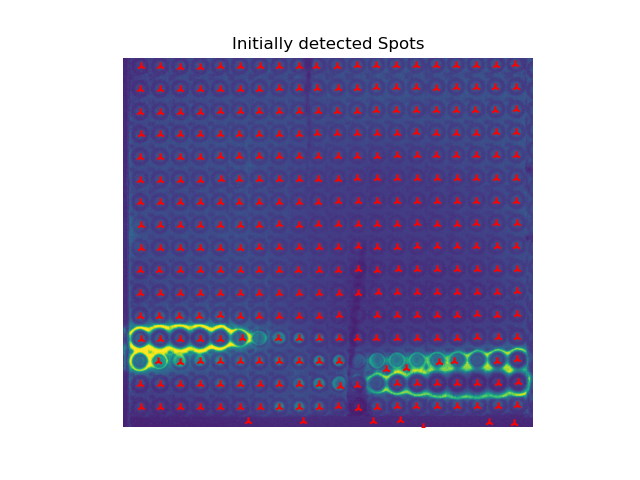

In [183]:
init_spots=spot.detect(raw_img,grid_props["spot_nr"])
init_spot_df=spot.create_df(init_spots)

fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.axis("off")
ax.set(title="Initially detected Spots")
ax.scatter(init_spot_df["x_coord"],init_spot_df["y_coord"],marker="2",c="red")

## Grid detection

In [184]:
class gridpoint:
    """
    ## Description

    Class containing information on points lying on a grid.

    ## __init__ Input:

    |Parameter|Type|Description|
    |---|---|---|
    |x|float|X-coordinate of the gridpoint|
    |y|float|Y-coordinate of the gridpoint|

    ## Class Attributes

    |Name|Description|
    |---|---|
    |x|X-coordinate of the gridpoint|
    |y|Y-coordinate of the gridpoint|
    |min_dist|Minimum distance of the gridpoint to a list of points. Default value is 100000.|
    """
    def __init__(self,x,y) -> None:
        self.x=x
        self.y=y
        self.min_dist=10000

    def eval_distance(self,spot_x,spot_y):
        """
        ## Description

        Calculates the distance between the gridpoint and another given point. 
        If the distance is smaller than the current min_dist, assign the new distance to min_dist.

        ## Input
        |Parameter|Type|Description|
        |---|---|---|
        |spot_x|float|X-coordinate of the other point|
        |spot_y|float|Y-coordinate of the other point|

        ## Output

        Distance between the 2 points
        """

        # Calculate the euclidean distance between the 2 points
        pointdist=np.linalg.norm(np.array((self.x,self.y))-np.array((spot_x,spot_y)))
        
        # Add the distance to the current gridpoint if it is smaller than all previously tested gridpoints.
        if pointdist<self.min_dist: 
            self.min_dist=pointdist
        
        return pointdist

class gridline:
    """
    ## Description

    Class containing information on lines lying on a grid.

    ## __init__ Input:

    |Parameter|Type|Description|
    |---|---|---|
    |angle|float|angle of the line in radians.|
    |distance|float|distance of the line from the origin|

    ## Class Attributes

    |Name|Description|
    |---|---|
    |dist|distance of the line from the origin|
    |angle|angle of the line in radians|
    |slope|slope of the line|
    |y_int|y-intercept of the line|
    |alignment|"hor" for horizontally and "vert" for vertically aligned lines|
    """

    def __init__(self, angle, distance):
        self.dist=distance
        self.angle=angle
        self.slope=np.tan(angle+np.pi/2)
        x0,y0=distance*np.array([np.cos(angle),np.sin(angle)])
        self.y_int=y0-self.slope*x0
        self.alignment=np.nan
    
    def __repr__(self):
        return f"y={self.slope:.2f}*x+{self.y_int:.2f}"

    def intersect(self,line2) -> tuple:
        """
        ## Description

        Calculates the intersect between the current line and another line object.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |line2|gridline|line to calculate the intersect with|

        ## Output

        Tuple containing the x and y coordinate of the line intersection.
        """
        
        # Calculation of the x and y coordinates of the line intersection.
        x=(line2.y_int-self.y_int)/(self.slope-line2.slope)
        y=self.slope*x+self.y_int
        
        point=gridpoint(x,y)
        return point
    
    @staticmethod
    def detect(img:np.array,max_tilt:int=5) -> list:
        """
        ## Description

        Determines lines lying on a grid from an image containing gridpoints.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |img|Array|np.array of an image containing gridpoints|
        |max_tilt|int|Maximum allowed tilt of the grid in degrees.|

        ## Output

        List of gridline objects.
        """

        # Create a hough-transform of the original image
        line_img,ang,dist=skimage.transform.hough_line(img)
        
        # Set the intensites of all lines with unwanted angles to 0.
        line_img[:,np.r_[max_tilt:89-max_tilt,91+max_tilt:180-max_tilt]]=0
        
        # Detect lines in the hough transformed image.
        accum,angle,distance=skimage.transform.hough_line_peaks(line_img,ang,dist,min_distance=80,threshold=0.2*line_img.max())
        
        # Saving all gridlines in a list
        gridlines=[gridline(a,d) for a,d in zip(angle,distance)]
        
        # Assigning horizontal and vertical lines.
        for line in gridlines: 
            if np.abs(np.rad2deg(line.angle))<=max_tilt: 
                line.alignment="hor"
            elif np.abs(np.rad2deg(line.angle))>=90-max_tilt: 
                line.alignment="vert"   
                
        return gridlines
        

Spot at Coordinates (1610, 1983) could not be drawn: Out of Bounds.


[Text(0.5, 1.0, 'Detected Spot-Grid')]

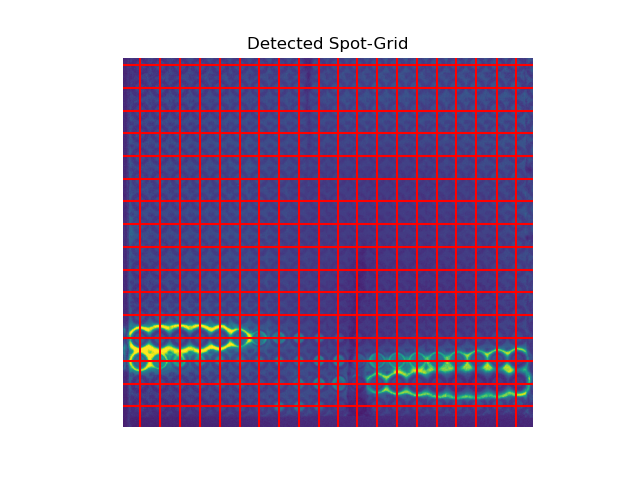

In [185]:
# Create an empty image and draw a dot for each detected spot.
dot_img=np.zeros(raw_img.shape)
for i_spot in init_spots: 
    i_spot.draw_spot(dot_img,255,5)

# Detection of gridlines.
gridlines=gridline.detect(dot_img)
hor_line=[line for line in gridlines if line.alignment=="hor"]
vert_line=[line for line in gridlines if line.alignment=="vert"]

# Calculate the intersections of all horizontal lines with all vertical lines.
grid_points=[]
for h_l in hor_line:
    for v_l in vert_line:
        grid_points.append(v_l.intersect(h_l))

# Display the grid.
fig,ax=plt.subplots()
ax.imshow(raw_img)
for item in hor_line+vert_line:
    ax.axline((0,item.y_int), slope=item.slope,c="r")
ax.set(ylim=[raw_img.shape[0],0],xlim=[0,raw_img.shape[1]])
ax.axis("off")
ax.set(title="Detected Spot-Grid")

## Spot Correction

,row,row_name,column,x_coord,y_coord,radius,halo,spot_intensity:,note
0,NaN,NaN,NaN,942,773,24,NaN,NaN,Initial Detection
1,NaN,NaN,NaN,729,1385,23,NaN,NaN,Initial Detection
2,NaN,NaN,NaN,623,530,23,NaN,NaN,Initial Detection
3,NaN,NaN,NaN,730,1018,24,NaN,NaN,Initial Detection
4,NaN,NaN,NaN,519,1263,24,NaN,NaN,Initial Detection
...,...,...,...,...,...,...,...,...,...
315,NaN,NaN,NaN,1256,1629,25,NaN,NaN,Backfilled
316,NaN,NaN,NaN,1468,1629,25,NaN,NaN,Backfilled
317,NaN,NaN,NaN,1788,1629,25,NaN,NaN,Backfilled
318,NaN,NaN,NaN,1153,1750,25,NaN,NaN,Backfilled


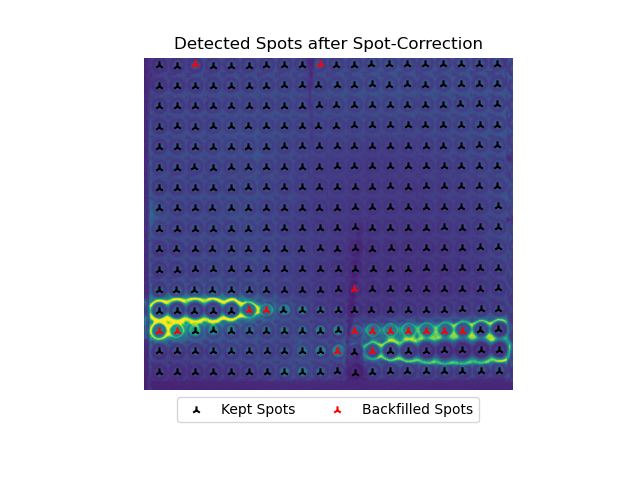

In [186]:
# Initializing corrected spotlist
corr_spots=[]

# Loop over all spots and gridpoints
for s_point in init_spots:
    dist_list=[]
    for g_point in grid_points:

        # Calculate the distance between the points and append it to the running list.
        pointdist=g_point.eval_distance(s_point.x,s_point.y)
        dist_list.append(pointdist)
    
    # If the distance between the current spot and any gridpoint is <= it is accepted as correct.
    if min(dist_list)<=10:
        corr_spots.append(s_point)

# Loop over all gridpoints and backfill the ones that are not associated with a spot.
for g_point in grid_points:
    if g_point.min_dist>10:
        spot.backfill(corr_spots,g_point.x,g_point.y)


# Display the corrected spotlist.
corr_spot=spot.create_df(corr_spots)

fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.scatter(corr_spot.loc[corr_spot["note"]=="Initial Detection","x_coord"],corr_spot.loc[corr_spot["note"]=="Initial Detection","y_coord"],marker="2",c="k",label="Kept Spots")
ax.scatter(corr_spot.loc[corr_spot["note"]=="Backfilled","x_coord"],corr_spot.loc[corr_spot["note"]=="Backfilled","y_coord"],marker="2",c="r",label="Backfilled Spots")
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
          fancybox=True,ncol=5)
ax.axis("off")
ax.set(title="Detected Spots after Spot-Correction")
corr_spot

## Halo Detection

In [187]:
class halo:
    """
    ## Description

    Class containing information on halos detected during halo-detection

    ## __init__ Input:

    |Parameter|Type|Description|
    |---|---|---|
    |x|float|x-coordinate of the halo|
    |y|float|y-coordinate of the halo|
    |rad|int|radius of the spot|

    ## Class Attributes

    |Name|Description|
    |---|---|
    |x|x-coordinate of the halo|
    |y|y-coordinate of the halo|
    |rad|radius of the halo|
    """
    def __init__(self,x,y,rad) -> None:
        self.x=x
        self.y=y
        self.rad=rad

    @staticmethod
    def detect(img):
        """
        ## Description

        Crude detection of halos in a grayscale image.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |img|np.array|Grayscale np.array of image to be analyzed|

        ## Output

        List of detected halos as halo-objects
        """
        
        # Create a mask of the image only containing halos.
        halo_mask=img<skimage.filters.threshold_yen(img)

        # Applying the mask to the histeq_img yields more consistent results for circle detection. The mask itself yields better results when calculated from the raw image.
        halo_img=skimage.filters.rank.equalize(skimage.util.img_as_ubyte(img),skimage.morphology.disk(50))
        halo_img[halo_mask]=0

        # Canny edge detection and follow up circle detection using hough transform.
        halo_edge=skimage.feature.canny(halo_img,3.52941866,44.78445877,44.78445877)
        halo_radii=np.arange(40,70) # Radii tested for.
        halo_hough=skimage.transform.hough_circle(halo_edge,halo_radii)

        h_accum,h_x,h_y,h_radii=skimage.transform.hough_circle_peaks(
            halo_hough,
            halo_radii,
            min_xdistance=70,
            min_ydistance=70,
            threshold=0.38546213*halo_hough.max()
            )
        
        halo_list=[halo(x,y,rad) for x,y,rad in zip(h_x,h_y,h_radii)]
        return halo_list
    
    @staticmethod
    def create_df(halo_list:list) -> pd.DataFrame:
        """
        ## Description

        Creates a DataFrame from a list of halos.

        ## Input

        |Parameter|Type|Description|
        |---|---|---|
        |halo_list|list|List of halo-objects to be turned into a DataFrame|

        ## Output

        DataFrame of halo-list.
        """

        halo_df=pd.DataFrame({"x_coord":[i_spot.x for i_spot in halo_list],
                              "y_coord":[i_spot.y for i_spot in halo_list],
                              "radius":[i_spot.rad for i_spot in halo_list]})
        
        return halo_df
        


[Text(0.5, 1.0, 'Detected Halos with corresponding Radius')]

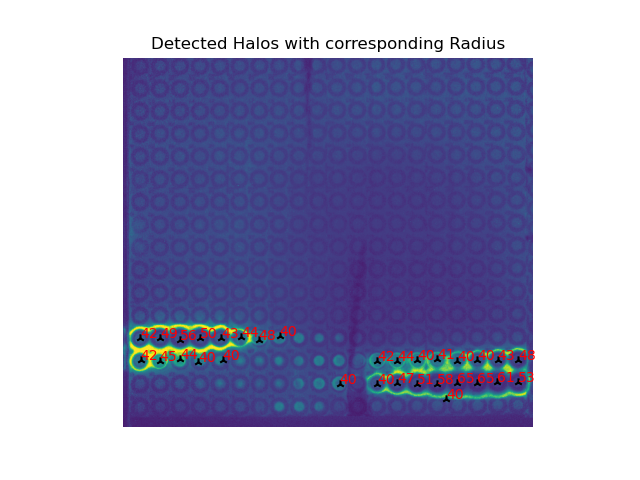

In [188]:
# Detect Halos using the halo.detect method.
halos=halo.detect(raw_img)
halo_df=halo.create_df(halos)

# Assign halos to their spot.
for s in corr_spots:
    s.assign_halo(halos)

# Displaying all detected Halos with their respective radii.
fig,ax=plt.subplots()
ax.imshow(raw_img)
ax.scatter(halo_df["x_coord"],halo_df["y_coord"],marker="2",c="k")
for idx in halo_df.index:
    ax.text(halo_df.loc[idx,"x_coord"], halo_df.loc[idx,"y_coord"], f'{halo_df.loc[idx,"radius"]}',c="r")
ax.axis("off")
ax.set(title="Detected Halos with corresponding Radius")

## Spot Sorting

In [189]:
spots_sorted=spot.sort_grid(corr_spots,
                            row_conv=row_conv_inv,
                            row_start=grid_props["rows"]["bounds"][0],
                            col_start=grid_props["columns"]["bounds"][0])


,row,row_name,column,x_coord,y_coord,radius,halo,spot_intensity:,note
0,1,A,1,93,46,23,NaN,NaN,Initial Detection
1,1,A,2,199,47,23,NaN,NaN,Initial Detection
2,1,A,3,303,40,25,NaN,NaN,Backfilled
3,1,A,4,411,48,24,NaN,NaN,Initial Detection
4,1,A,5,519,47,24,NaN,NaN,Initial Detection
...,...,...,...,...,...,...,...,...,...
315,16,P,16,1684,1869,25,NaN,NaN,Initial Detection
316,16,P,17,1793,1869,25,NaN,NaN,Initial Detection
317,16,P,18,1900,1869,24,NaN,NaN,Initial Detection
318,16,P,19,2014,1868,20,NaN,NaN,Initial Detection


## Determination of Spot-Intensities

column,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
row_name,,,,,,,,,,,,,,,,,,,,
A,0.560014,0.577184,0.573282,0.580311,0.584947,0.583514,0.585619,0.583472,0.583948,0.580511,0.585864,0.587613,0.595443,0.592468,0.591761,0.593319,0.589557,0.598025,0.594108,0.591179
B,0.568884,0.578840,0.582413,0.582858,0.586799,0.584868,0.585981,0.586504,0.588366,0.587819,0.590423,0.592024,0.602294,0.593731,0.592803,0.588981,0.590133,0.596428,0.595895,0.598928
C,0.574916,0.583654,0.580022,0.583983,0.584038,0.587313,0.589020,0.587946,0.587260,0.583222,0.586907,0.588086,0.591458,0.591003,0.587708,0.588615,0.592473,0.593137,0.594580,0.598273
D,0.578321,0.583858,0.586019,0.584087,0.593025,0.590476,0.589638,0.587424,0.581784,0.581121,0.579386,0.579432,0.581465,0.579042,0.580260,0.584362,0.585229,0.590509,0.594031,0.596990
E,0.580999,0.586181,0.588405,0.583976,0.592536,0.587993,0.589546,0.581567,0.578255,0.573485,0.575096,0.568498,0.566343,0.567143,0.571501,0.574097,0.579270,0.583013,0.588448,0.592806
F,0.578606,0.585460,0.585527,0.584272,0.589013,0.588154,0.584657,0.578606,0.571707,0.566440,0.566306,0.560421,0.557218,0.559277,0.561900,0.563730,0.568891,0.572862,0.582463,0.587700
G,0.579674,0.584865,0.584493,0.586473,0.585798,0.587755,0.584198,0.574151,0.571745,0.563945,0.562310,0.557980,0.556026,0.558533,0.557599,0.558800,0.563268,0.569765,0.578443,0.585397
H,0.593059,0.584189,0.584005,0.587356,0.589184,0.591727,0.580188,0.577573,0.566332,0.562203,0.557759,0.555545,0.553989,0.556197,0.556177,0.557451,0.560583,0.566700,0.571826,0.587768
I,0.587631,0.581004,0.584770,0.586319,0.587241,0.590114,0.582212,0.573739,0.565679,0.560602,0.556164,0.551174,0.550898,0.552426,0.552448,0.555861,0.560041,0.562268,0.571302,0.584744


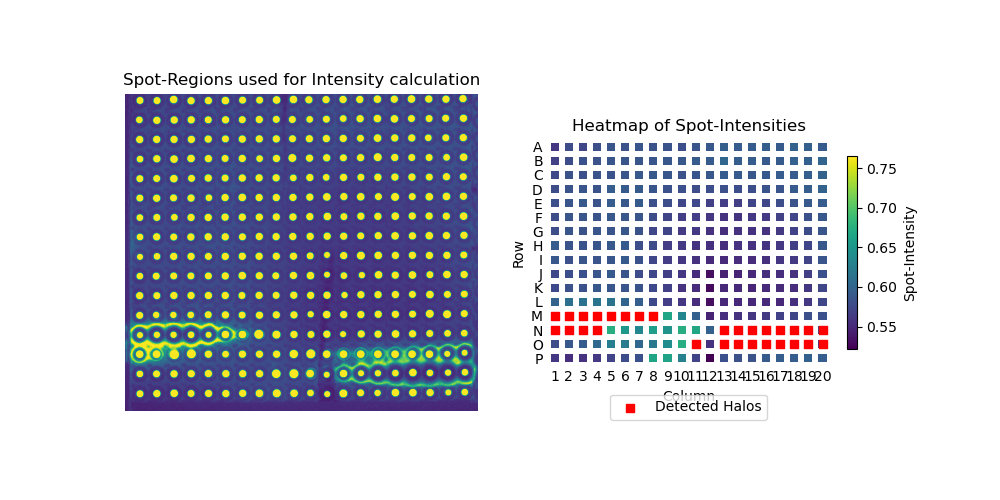

In [197]:
spot_img=raw_img.copy()
for s in spots_sorted:
    s.get_intensity(raw_img)
    s.draw_spot(spot_img)

sort_df=spot.create_df(spots_sorted)
heatmap=sort_df.pivot_table(index="row_name",columns="column",values="spot_intensity")

# Display Image and corresponding Heatmap
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(spot_img)
ax[0].axis("off")
ax[0].set(title="Spot-Regions used for Intensity calculation")

htmp=ax[1].pcolormesh(heatmap.iloc[::-1],edgecolors="white",linewidth=4)
ax[1].set(title="Heatmap of Spot-Intensities",
          aspect="equal",
          ylabel="Row",
          xlabel="Column",
          yticks=np.array(range(1,len(heatmap)+1))-0.5,
          xticks=np.array(range(1,len(heatmap.columns)+1))-0.5,
          yticklabels=heatmap.index[::-1],
          xticklabels=heatmap.columns
          )
ax[1].spines[["right","left","top","bottom"]].set_visible(False)
ax[1].tick_params(axis=u'both', which=u'both',length=0)
ax[1].scatter(sort_df.loc[sort_df["halo"]>0,"column"]-(math.floor((grid_props["columns"]["bounds"][0])/10)*10)-0.5,grid_props["rows"]["length"]+0.5-sort_df.loc[sort_df["halo"]>0,"row"],marker="s", c="red",label="Detected Halos")
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True,ncol=5)
fig.colorbar(htmp,ax=ax[1],label="Spot-Intensity",shrink=0.5)
heatmap

KeyError: 'halo_rad'

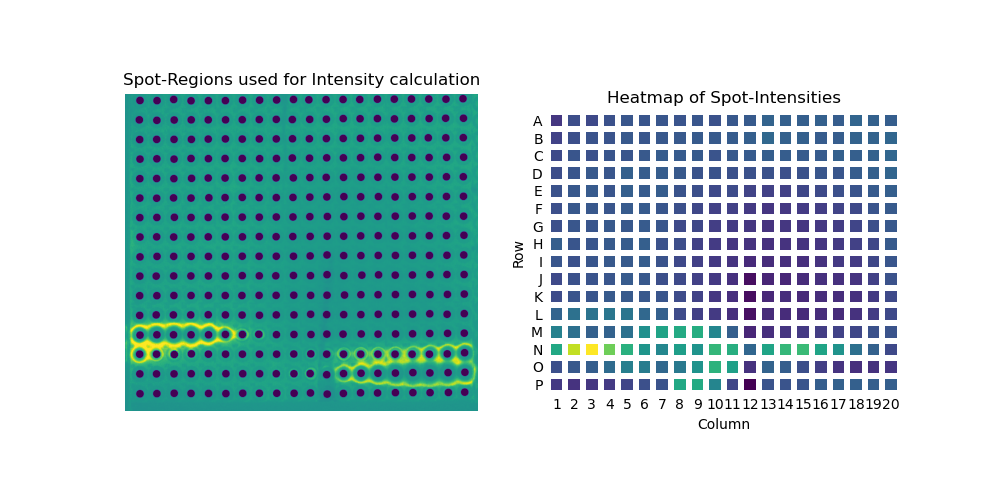

In [191]:
spot_img=raw_img.copy()
sort_spot["spot_intensity"]=np.nan

# Looping through all spots.
for idx in sort_spot.index:
    # Try to extract all pixel indices of the current spot, otherwise print an error.
    try:
        # Indices of all pixels part of the current spot
        rr,cc=skimage.draw.disk((sort_spot.loc[idx,"y_coord"],sort_spot.loc[idx,"x_coord"]),25)
        # Mean intensity of all pixels within the spot
        sort_spot.loc[idx,"spot_intensity"]=raw_img[rr,cc].sum()/len(rr)
        # Creating an image with all spots Highlighted
        spot_img[rr,cc]=0
    
    except:
        print(f"Spot at Coordinates ({sort_spot.loc[idx,'x_coord']}, {sort_spot.loc[idx,'y_coord']}) could not be drawn: Out of Bounds.")

# Create a heatmap of all spots of the current image
heatmap=sort_spot.pivot_table(index="row_letter",columns="column",values="spot_intensity")

# Display Image and corresponding Heatmap
fig,ax=plt.subplots(1,2,figsize=(10,5))
ax[0].imshow(spot_img)
ax[0].axis("off")
ax[0].set(title="Spot-Regions used for Intensity calculation")

htmp=ax[1].pcolormesh(heatmap.iloc[::-1],edgecolors="white",linewidth=4)
ax[1].set(title="Heatmap of Spot-Intensities",
          aspect="equal",
          ylabel="Row",
          xlabel="Column",
          yticks=np.array(range(1,len(heatmap)+1))-0.5,
          xticks=np.array(range(1,len(heatmap.columns)+1))-0.5,
          yticklabels=heatmap.index[::-1],
          xticklabels=heatmap.columns
          )
ax[1].spines[["right","left","top","bottom"]].set_visible(False)
ax[1].tick_params(axis=u'both', which=u'both',length=0)
ax[1].scatter(sort_spot.loc[sort_spot["halo_rad"]>0,"column"]-(math.floor((grid_props["columns"]["bounds"][0])/10)*10)-0.5,row_nr-0.5-sort_spot.loc[sort_spot["halo_rad"]>0,"row"],marker="s", c="red",label="Detected Halos")
box = ax[1].get_position()
ax[1].set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
ax[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
          fancybox=True,ncol=5)
fig.colorbar(htmp,ax=ax[1],label="Spot-Intensity",shrink=0.5)
heatmap

## Save Results

In [ ]:
# Create the output-folder if it does not exist already
if not outputfolder.exists():
    outputfolder.mkdir()

# Generate path for output-file
filename=inputfile.name.split(".")[0]+"_spotlist.csv"
outputfile=outputfolder/filename

# Write a csv-file of the results.
sort_spot.to_csv(outputfile)